## In this notebook the police-department-calls-for-service datasets is explored

In [1]:
#### importing required python packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



In [2]:
#### reading in the data
calls = pd.read_csv('../data/sf-police-calls-for-service-and-incidents/police-department-calls-for-service.csv')

## general information about the "calls" dataset

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035330 entries, 0 to 3035329
Data columns (total 14 columns):
Crime Id                    int64
Original Crime Type Name    object
Report Date                 object
Call Date                   object
Offense Date                object
Call Time                   object
Call Date Time              object
Disposition                 object
Address                     object
City                        object
State                       object
Agency Id                   int64
Address Type                object
Common Location             object
dtypes: int64(2), object(12)
memory usage: 324.2+ MB


The calls dataframe has over 3M rows and a total of 14 columns. Crime Id and Agency Id columns are integers and the rest of the columns are of type string. We will convert Report Date, call Date, Offense Date, Call Time, and Call Date Time to datetime objects. 

## Missing values in the "calls" dataset

In [4]:
calls.isna().sum()

Crime Id                          0
Original Crime Type Name          0
Report Date                       0
Call Date                         0
Offense Date                      0
Call Time                         0
Call Date Time                    0
Disposition                       0
Address                           0
City                          75502
State                             0
Agency Id                         0
Address Type                      0
Common Location             2708815
dtype: int64

The only missing values in the "calls" dataframe exist in columns City and Common Location. We'll take a closer look at the rows that include missing values in these two columns. 

In [5]:
calls_missing_common_location = calls.loc[calls['Common Location'].isna()]
calls_non_missing_common_location = calls.loc[~ calls['Common Location'].isna()]

Let's see what is the address type of the rows with missing and non-missing "Common Location" column:

In [6]:
calls_non_missing_common_location['Address Type'].unique()

array(['Common Location'], dtype=object)

In [7]:
calls_missing_common_location['Address Type'].unique()

array(['Premise Address', 'Intersection', 'Geo-Override'], dtype=object)

Ok! so the "Common Location" column has missing values for all the rows where the Address Type is not "Common Location". 

Now let's take a look at the missing values at the "City" column.

In [8]:
calls_missing_city = calls.loc[calls['City'].isna()]
calls_non_missing_city = calls.loc[~ calls['City'].isna()]

We will check to see if the addresses in the missing city dataframe exist in other rows of the dataframe with non-missing city names.

In [9]:
common_addresses = set(calls_missing_city['Address'].values).intersection(set(calls_non_missing_city['Address'].values))
common_addresses = list(common_addresses)
len(common_addresses)

231

We see that in 231 of the addrersses with missing cities, that address exists in the calls-non-missing-city dataframe. So with the assumption that those redundant addresses came from the same city, we substitute the missing city name with the existing city name where the addresses are the same. 

In [10]:
for i in range(len(common_addresses)):
    calls.loc[(calls['City'].isna())&(calls['Address'] == common_addresses[i]),'City'] = calls.loc[(~ calls['City'].isna())&(calls['Address'] == common_addresses[i])]['City'].values[0]

In [11]:
calls.isna().sum()

Crime Id                          0
Original Crime Type Name          0
Report Date                       0
Call Date                         0
Offense Date                      0
Call Time                         0
Call Date Time                    0
Disposition                       0
Address                           0
City                          73698
State                             0
Agency Id                         0
Address Type                      0
Common Location             2708815
dtype: int64

We see now that the number of missing "City" rows declined from 75502 to 73698. There are other ways we could try to find out the missing City names but for the purpose of this general analysis, we will remove the rows with missing City names (2.43 % of the data). However, before doing so, we will look at distribution of Crime type, Disposition, and Crime time to ensure that the rows with missing City names that we intend to remove don't have a significantly different distribution than the rest of the rows (i.e. ensuring that missing cities are not biased towards calls that were made at a particular time of day, etc.)

## Crime Id

We'll check to see if Crime Id is the unique identifier of the call:

In [12]:
len(calls['Crime Id'].unique()) == len(calls)

True

Yes! Crime Id is unique for each service call. 

In [13]:
## Agency Id

In [14]:
calls['Agency Id'].unique()

array([1])

The value of "Agency Id" column is 1 for all the calls in this dataframe.

## Original Crime Type Name

Let's see what the most common crime types are:

In [15]:
Crime_Types_Freq = calls.groupby('Original Crime Type Name')['Crime Id'].count().sort_values(ascending = False).reset_index()
Crime_Types_Freq.rename(columns = {'Crime Id':'Count'}, inplace = True)

In [16]:
Crime_Types_Freq['Percent'] = Crime_Types_Freq['Count']/Crime_Types_Freq['Count'].sum()*100

In [17]:
Crime_Types_Freq

,Original Crime Type Name,Count,Percent
0,Passing Call,447929,14.757176
1,Traffic Stop,284572,9.375323
2,Suspicious Person,151450,4.989573
3,Homeless Complaint,142353,4.689869
4,22500e,104197,3.432806
...,...,...,...
22267,Male 586,1,0.000033
22268,Male 311,1,0.000033
22269,Male /Poss,1,0.000033
22270,Male / Ranting,1,0.000033


Plotting the most common crime types in service calls:

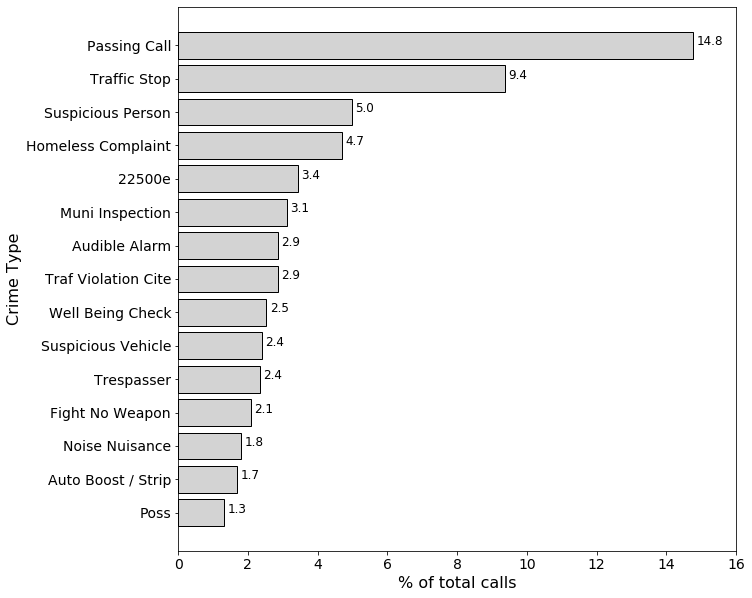

In [18]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(Crime_Types_Freq['Original Crime Type Name'].values[0:15][::-1],
        Crime_Types_Freq['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total calls', fontsize = 16)
plt.ylabel('Crime Type', fontsize = 16)

for i in range(len(Crime_Types_Freq['Original Crime Type Name'].values[0:15][::-1])):
    plt.text(Crime_Types_Freq['Percent'].values[0:15][::-1][i]+0.1 , i , 
             round(Crime_Types_Freq['Percent'].values[0:15][::-1][i],1), fontsize = 12)

plt.xlim(0,16)
plt.savefig ('../Plots/calls/Percent_all_calls_by_type.pdf', bbox_inches = 'tight')

In [19]:
Top_15_Crime_Types = Crime_Types_Freq['Original Crime Type Name'].values[0:15][::-1]

Are the distribution of Crime Types different between calls with or without missing City? 

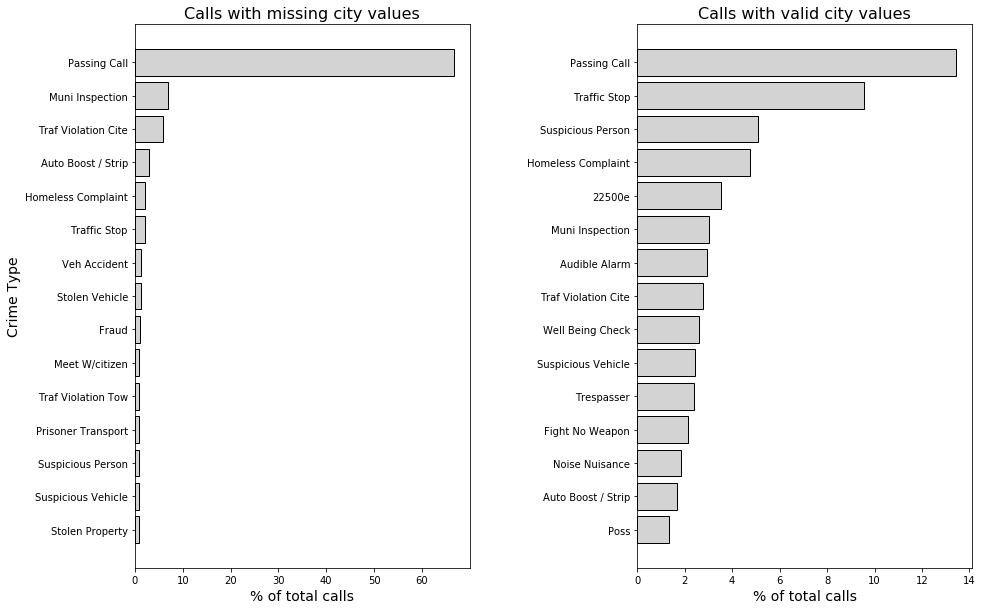

In [20]:
Crime_Types_Freq_missing_city = calls_missing_city.groupby('Original Crime Type Name')['Crime Id'].count().sort_values(ascending = False).reset_index()
Crime_Types_Freq_missing_city.rename(columns = {'Crime Id':'Count'}, inplace = True)
Crime_Types_Freq_missing_city['Percent'] = Crime_Types_Freq_missing_city['Count']/Crime_Types_Freq_missing_city['Count'].sum()*100

Crime_Types_Freq_no_missing_city = calls_non_missing_city.groupby('Original Crime Type Name')['Crime Id'].count().sort_values(ascending = False).reset_index()
Crime_Types_Freq_no_missing_city.rename(columns = {'Crime Id':'Count'}, inplace = True)
Crime_Types_Freq_no_missing_city['Percent'] = Crime_Types_Freq_no_missing_city['Count']/Crime_Types_Freq_no_missing_city['Count'].sum()*100


fig = plt.figure(figsize = (15,10))
ax1  = fig.add_subplot(1,2,1)
plt.barh(Crime_Types_Freq_missing_city['Original Crime Type Name'].values[0:15][::-1],
        Crime_Types_Freq_missing_city['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')

plt.xlabel('% of total calls', fontsize = 14)
plt.ylabel('Crime Type', fontsize = 14)
plt.title('Calls with missing city values', fontsize = 16)

ax2  = fig.add_subplot(1,2,2)
plt.barh(Crime_Types_Freq_no_missing_city['Original Crime Type Name'].values[0:15][::-1],
        Crime_Types_Freq_no_missing_city['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')
plt.xlabel('% of total calls', fontsize = 14)
plt.title('Calls with valid city values', fontsize = 16)

plt.subplots_adjust( wspace=0.5)
plt.savefig ('../Plots/calls/Percent_all_calls_by_type_missingCity.pdf', bbox_inches = 'tight')

We see that more than 60% of calls with missing city values are "passing call"s and that the distribution of crime types for the calls with missing city values is different than for the ones with valid city values. 

## State and City
Since the audience of this analysis is the Mayor of San Francisco, we will first look at distribution of calls per city and then focus the rest of the analysis to the calls involving addresses in the city of San Francisco. 

In [21]:
calls['State'].unique()

array(['CA'], dtype=object)

The value of State column for all the calls is "CA". 

In [22]:
calls['City'].unique()

array(['San Francisco', 'Yerba Buena', 'Treasure Isla', 'Hunters Point',
       nan, 'Presidio', 'Daly City', 'Fort Mason', 'Brisbane'],
      dtype=object)

Calls in this dataframe come from 8 different Cities. Let's look at distribution of calls by city.

In [23]:
calls_by_city = calls.groupby('City')['Crime Id'].count().sort_values(ascending = False).reset_index()

In [24]:
calls_by_city.rename (columns = {'Crime Id':'Count'}, inplace = True)
nan_df = pd.DataFrame()
nan_df['City'] = ['Missing']
nan_df['Count'] = calls['City'].isna().sum()
calls_by_city = calls_by_city.append(nan_df)

calls_by_city['Percent'] = calls_by_city['Count']/calls_by_city['Count'].sum()*100
calls_by_city

,City,Count,Percent
0,San Francisco,2935335,96.705630
1,Treasure Isla,20117,0.662762
2,Yerba Buena,2836,0.093433
3,Daly City,1421,0.046815
4,Hunters Point,907,0.029881
5,Presidio,875,0.028827
6,Fort Mason,89,0.002932
7,Brisbane,52,0.001713
0,Missing,73698,2.428006


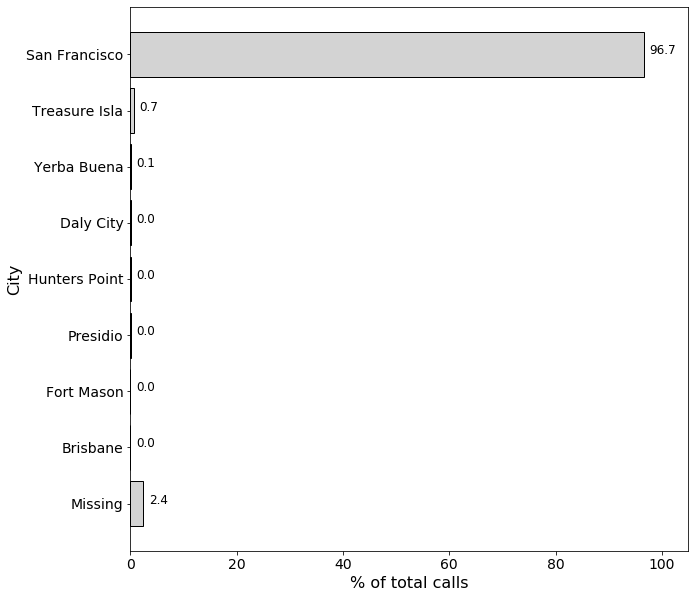

In [25]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(calls_by_city['City'].values[::-1],
        calls_by_city['Percent'].values[::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total calls', fontsize = 16)
plt.ylabel('City', fontsize = 16)

for i in range(len(calls_by_city['City'].values[::-1])):
    plt.text(calls_by_city['Percent'].values[::-1][i]+1 , i , 
             round(calls_by_city['Percent'].values[::-1][i],1), fontsize = 12)
    
plt.xlim(0,105)
plt.savefig ('../Plots/calls/Percent_all_calls_by_city.pdf', bbox_inches = 'tight')

More than 96% of the calls are associated with addresses in the City of San Francisco. For the rest of the analysis, we will just focus on San Francisco service calls.

In [26]:
calls = calls.loc[calls['City'] == 'San Francisco']

## Address Type and Common Location
Here we take a look at distribution of calls by address type and by different common locations.

In [27]:
calls['Address Type'].unique()

array(['Premise Address', 'Intersection', 'Common Location',
       'Geo-Override'], dtype=object)

In [28]:
calls_by_address_type = calls.groupby('Address Type')['Crime Id'].count().sort_values(ascending = False).reset_index()
calls_by_address_type.rename(columns = {'Crime Id':'Count'}, inplace = True)
calls_by_address_type['Percent'] = calls_by_address_type['Count']/calls_by_address_type['Count'].sum()*100

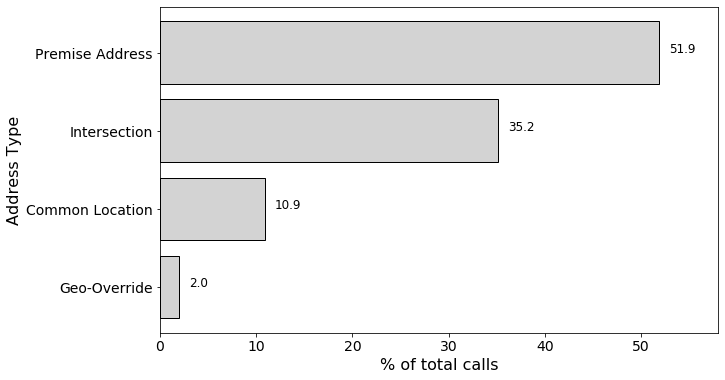

In [29]:
fig = plt.figure(figsize = (10,6))
ax  = fig.add_subplot(1,1,1)
plt.barh(calls_by_address_type['Address Type'].values[::-1],
        calls_by_address_type['Percent'].values[::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total calls', fontsize = 16)
plt.ylabel('Address Type', fontsize = 16)

for i in range(len(calls_by_address_type['Address Type'].values[::-1])):
    plt.text(calls_by_address_type['Percent'].values[::-1][i]+1 , i , 
             round(calls_by_address_type['Percent'].values[::-1][i],1), fontsize = 12)
    
plt.xlim(0,58)
plt.savefig ('../Plots/calls/Percent_all_calls_by_address_type.pdf', bbox_inches = 'tight')

We see that most of the calls are associated with Premise Addresses followed by Intersection and Common Locations. The dataset provides more information about which common locations the calls were associated with. Let's look at the most common common locations.

In [30]:
calls_common_location = calls.loc[calls['Address Type'] == 'Common Location']

In [31]:
calls_common_location_by_location = calls_common_location.groupby('Common Location')['Crime Id'].count().sort_values(ascending = False).reset_index()

In [32]:
calls_common_location_by_location.rename(columns = {'Crime Id':'Count'}, inplace = True)
calls_common_location_by_location['Percent'] = calls_common_location_by_location['Count']/calls_common_location_by_location['Count'].sum()*100

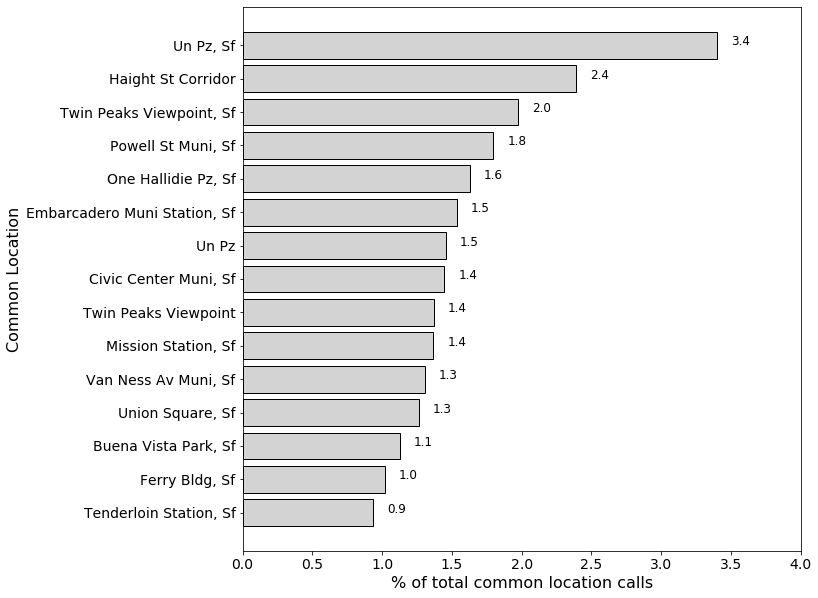

In [33]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(calls_common_location_by_location['Common Location'].values[0:15][::-1],
        calls_common_location_by_location['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total common location calls', fontsize = 16)
plt.ylabel('Common Location', fontsize = 16)

for i in range(len(calls_common_location_by_location['Common Location'].values[0:15][::-1])):
    plt.text(calls_common_location_by_location['Percent'].values[0:15][::-1][i]+0.1 , i , 
             round(calls_common_location_by_location['Percent'].values[0:15][::-1][i],1), fontsize = 12)
    
plt.xlim(0,4)
plt.savefig ('../Plots/calls/Percent_all_calls_by_CommonLocationType.pdf', bbox_inches = 'tight')

Seems like some of the common locations refer to the same location but use different names. ex. Un Pz, sf and Un Pz. 
We will redo the analysis above by first converting the common addresses to upper case and removing the comma and city from the common location names. Note that at this point we are only analyzing San Francisco calls.  

In [34]:
calls_common_location = calls.loc[calls['Address Type'] == 'Common Location']
calls_common_location['Common Location'] = calls_common_location['Common Location'].apply(lambda x: x.upper().replace(', SF', ''))





In [35]:
calls_common_location_by_location = calls_common_location.groupby('Common Location')['Crime Id'].count().sort_values(ascending = False).reset_index()
calls_common_location_by_location.rename(columns = {'Crime Id':'Count'}, inplace = True)
calls_common_location_by_location['Percent'] = calls_common_location_by_location['Count']/calls_common_location_by_location['Count'].sum()*100


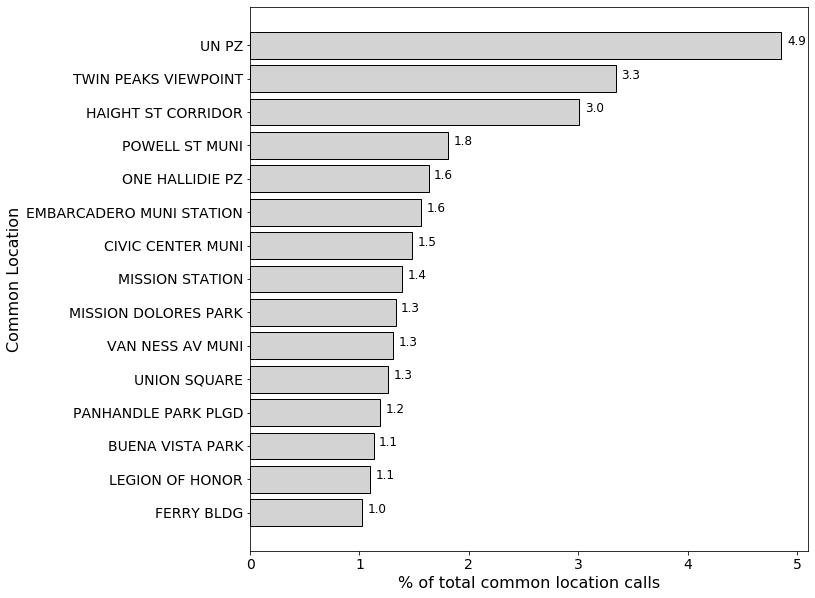

In [36]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(calls_common_location_by_location['Common Location'].values[0:15][::-1],
        calls_common_location_by_location['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total common location calls', fontsize = 16)
plt.ylabel('Common Location', fontsize = 16)

for i in range(len(calls_common_location_by_location['Common Location'].values[0:15][::-1])):
    plt.text(calls_common_location_by_location['Percent'].values[0:15][::-1][i]+0.05 , i , 
             round(calls_common_location_by_location['Percent'].values[0:15][::-1][i],1), fontsize = 12)
    
# plt.xlim(0,4)
plt.savefig ('../Plots/calls/Percent_all_calls_by_CommonLocationTypeUpdated.pdf', bbox_inches = 'tight')

We see that about 5% of all common location calls were related to Un Pz. 

## Disposition
Now we'll look at distribution of calls by disposition. There are 37 different disposition types that here we'll take a look at the top 10. 

In [37]:
calls['Disposition'].unique()

array(['HAN', 'CAN', 'ADV', 'NOM', 'UTL', 'REP', 'GOA', 'Not recorded',
       'CIT', 'ND', 'NCR', 'ARR', 'PAS', '22', 'ADM', 'ABA', 'GEN', 'INC',
       'SFD', '47A', 'CRM', 'ENC', 'DUP', 'CLN', 'OTS', 'TOW', 'CHP',
       'FIR', 'MAP', 'VAS', 'HOT', 'INS', 'OME', 'TH2', 'PDT', 'POL',
       'CRT', 'TH3'], dtype=object)

In [38]:
calls_by_disposition = calls.groupby('Disposition')['Crime Id'].count().sort_values(ascending = False).reset_index()
calls_by_disposition.rename(columns = {'Crime Id':'Count'}, inplace = True)
calls_by_disposition['Percent'] = calls_by_disposition ['Count']/calls_by_disposition['Count'].sum()*100

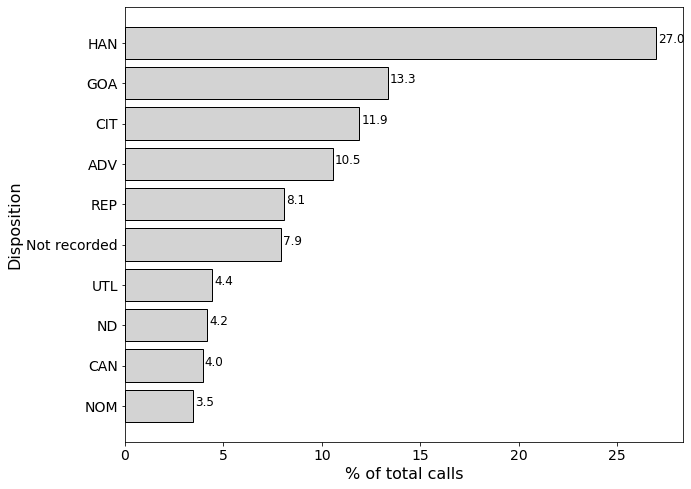

In [39]:
fig = plt.figure(figsize = (10,8))
ax  = fig.add_subplot(1,1,1)
plt.barh(calls_by_disposition['Disposition'].values[0:10][::-1],
        calls_by_disposition['Percent'].values[0:10][::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total calls', fontsize = 16)
plt.ylabel('Disposition', fontsize = 16)

for i in range(len(calls_by_disposition['Disposition'].values[0:10][::-1])):
    plt.text(calls_by_disposition['Percent'].values[0:10][::-1][i]+0.1 , i , 
             round(calls_by_disposition['Percent'].values[0:10][::-1][i],1), fontsize = 12)
    
# plt.xlim(0,4)
plt.savefig ('../Plots/calls/Percent_all_calls_by_Disposition.pdf', bbox_inches = 'tight')

## Report Date, Call Date, Offense Date

We will first convert report date, call date, and offense date to datetime objects. 
As a sanity check, we'll check to ensure that offense date <= call date <= report date. 
We will also check and see that call date + call time == call date time column.

In [40]:
calls['Report Date'] = pd.to_datetime(calls['Report Date'])
calls['Call Date'] = pd.to_datetime(calls['Call Date'])
calls['Offense Date'] = pd.to_datetime(calls['Offense Date'])
calls['Call Date Time'] = pd.to_datetime(calls['Call Date Time'])

In [41]:
####### is call date larger than or equal to offence date?
calls['call_offence_diff'] = calls['Call Date']-calls['Offense Date']
calls['call_offence_diff'] = calls['call_offence_diff'].apply(lambda x: x.days)
calls['call_offence_diff'].describe()

count    2935335.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: call_offence_diff, dtype: float64

All calls were placed on the same day as the offense.

In [42]:
####### is report date larger than or equal to call date?
calls['report_call_diff'] = calls['Report Date'] - calls['Call Date']
calls['report_call_diff'] = calls['report_call_diff'].apply(lambda x: x.days)
calls['report_call_diff'].describe()

count    2935335.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: report_call_diff, dtype: float64

All reports were made on the same day as the call.

Now we check if call date + call time == call date time column.

In [43]:
calls['Date Plus Time'] = calls['Call Date'].astype(str)+' '+calls['Call Time']

In [44]:
(pd.to_datetime(calls['Date Plus Time']) - calls['Call Date Time']).min()

Timedelta('0 days 00:00:00')

In [45]:
(pd.to_datetime(calls['Date Plus Time']) - calls['Call Date Time']).max()

Timedelta('0 days 00:00:00')

Therefore, call date + call time == call date time column.
Let's remove the extra columns we added to the dataframe for these sanity checks.

In [46]:
calls.drop (['call_offence_diff', 'report_call_diff', 'Date Plus Time'], axis = 1 , inplace = True)

In [47]:
print ( 'Date Time of the First Call in the Dataset:', calls['Call Date Time'].min())
print ( 'Date Time of the Last Call in the Dataset:', calls['Call Date Time'].max())

Date Time of the First Call in the Dataset: 2016-03-30 18:42:00
Date Time of the Last Call in the Dataset: 2019-11-23 23:54:00


## time-of-day distribution of calls:

In [48]:
calls['Hour'] = calls['Call Date Time'].dt.hour

In [49]:
##### Percent of Total calls in each hour
total_calls_by_hour = calls.groupby('Hour')['Crime Id'].count().reset_index()
total_calls_by_hour.rename(columns = {'Crime Id':'Count'}, inplace = True)
total_calls_by_hour['Percent'] = total_calls_by_hour['Count']/total_calls_by_hour['Count'].sum()*100

In [50]:
total_calls_by_hour.index = total_calls_by_hour['Hour']
total_calls_by_hour.drop(['Hour','Count'], axis = 1, inplace = True)

In [51]:
total_calls_by_hour = total_calls_by_hour.transpose()
total_calls_by_hour.index = ['All Crime Types']


In [52]:
total_calls_by_hour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
All Crime Types,2.927162,2.275549,1.949352,1.497001,1.327446,1.381546,2.221007,4.034599,4.815328,5.144932,...,5.125684,5.228568,6.631304,6.818404,6.24157,5.111989,4.135405,4.03511,4.417281,3.785088


In [53]:
##### Percent of Total calls in each hour for the top 15 crime types

In [54]:
calls_top15_crime_types = calls.loc[calls['Original Crime Type Name'].isin(Top_15_Crime_Types)]
total_calls_by_type_by_hour = calls_top15_crime_types.groupby(['Original Crime Type Name','Hour'])['Crime Id'].count().unstack()

In [55]:
total_calls_by_type_by_hour['total'] = total_calls_by_type_by_hour.sum(axis = 1)
total_calls_by_type_by_hour.sort_values('total', inplace = True, ascending = False)

In [56]:
total_calls_by_type_by_hour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,total
Original Crime Type Name,,,,,,,,,,,,,,,,,,,,,
Passing Call,9903.0,7564.0,5217.0,4967.0,5392.0,4413.0,7232.0,17076.0,17927.0,19655.0,...,18513.0,31992.0,31497.0,26253.0,18007.0,9397.0,10690.0,16974.0,14280.0,382519.0
Traffic Stop,9722.0,5161.0,3535.0,2454.0,2640.0,2216.0,2414.0,9124.0,13428.0,14432.0,...,16512.0,25621.0,24522.0,17919.0,12847.0,8459.0,10137.0,17043.0,14663.0,282529.0
Suspicious Person,4857.0,3638.0,2970.0,2463.0,1949.0,1523.0,2344.0,4965.0,5758.0,6484.0,...,9658.0,10283.0,9714.0,8469.0,7367.0,5472.0,5095.0,5958.0,5931.0,150781.0
Homeless Complaint,1689.0,1184.0,915.0,1046.0,1848.0,4703.0,9576.0,14993.0,13652.0,12513.0,...,5555.0,5997.0,5410.0,4819.0,4393.0,3503.0,3219.0,2796.0,2256.0,140739.0
22500e,18.0,NaN,2.0,1.0,4.0,16.0,2422.0,4259.0,5532.0,6047.0,...,5451.0,7115.0,7744.0,8760.0,8674.0,6932.0,5607.0,4080.0,2063.0,104161.0


In [57]:
total_calls_by_type_by_hour_Fraction = total_calls_by_type_by_hour.div(total_calls_by_type_by_hour['total'], axis = 0)*100

In [58]:
total_calls_by_type_by_hour_Fraction.drop(['total'], axis = 1, inplace = True)

In [59]:
total_calls_by_type_by_hour_Fraction.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Original Crime Type Name,,,,,,,,,,,,,,,,,,,,,
Passing Call,2.588891,1.977418,1.363854,1.298498,1.409603,1.153668,1.890625,4.464092,4.686565,5.138307,...,5.163665,4.839760,8.363506,8.234101,6.863188,4.707479,2.456610,2.794632,4.437427,3.733148
Traffic Stop,3.441063,1.826715,1.251199,0.868583,0.934417,0.784344,0.854426,3.229403,4.752786,5.108148,...,5.196989,5.844356,9.068450,8.679463,6.342358,4.547144,2.994029,3.587950,6.032301,5.189910
Suspicious Person,3.221228,2.412771,1.969744,1.633495,1.292603,1.010074,1.554573,3.292855,3.818784,4.300277,...,6.635451,6.405316,6.819825,6.442456,5.616755,4.885894,3.629104,3.379073,3.951426,3.933519
Homeless Complaint,1.200094,0.841274,0.650140,0.743220,1.313069,3.341647,6.804084,10.653053,9.700225,8.890926,...,4.236921,3.947023,4.261079,3.843995,3.424069,3.121381,2.489004,2.287212,1.986656,1.602967
22500e,0.017281,NaN,0.001920,0.000960,0.003840,0.015361,2.325246,4.088862,5.311009,5.805436,...,5.488619,5.233245,6.830772,7.434644,8.410058,8.327493,6.655082,5.383013,3.917013,1.980588


In [60]:
total_calls_by_type_by_hour_Fraction = total_calls_by_type_by_hour_Fraction.append(total_calls_by_hour)

In [61]:
total_calls_by_type_by_hour_Fraction = total_calls_by_type_by_hour_Fraction.fillna(0)

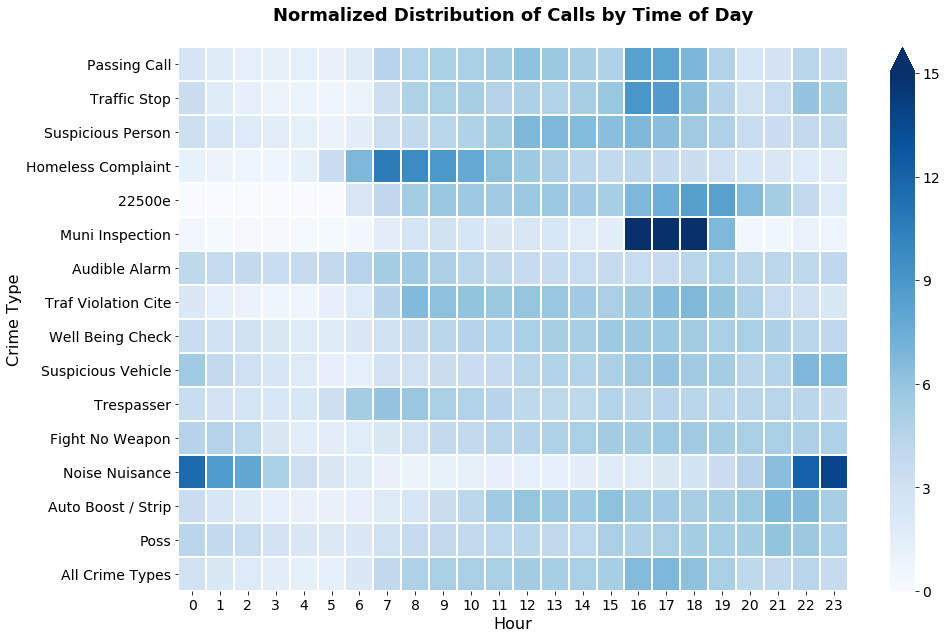

In [62]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
cbar_kws = {
            'extend':'max'
           }
sns.heatmap(total_calls_by_type_by_hour_Fraction , cmap="Blues",linewidth = 1, vmin = 0, vmax = 15, cbar_kws = cbar_kws)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel ('Hour' , fontsize = 16)
plt.ylabel ('Crime Type', fontsize = 16)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Normalized Distribution of Calls by Time of Day\n', fontsize = 18 , fontweight = 'bold')
plt.savefig ('../Plots/calls/Hourly_Distribution_all_calls_by_type.pdf', bbox_inches = 'tight')

## Day of Week Distribution of calls 

In [63]:
calls.columns

Index(['Crime Id', 'Original Crime Type Name', 'Report Date', 'Call Date',
       'Offense Date', 'Call Time', 'Call Date Time', 'Disposition', 'Address',
       'City', 'State', 'Agency Id', 'Address Type', 'Common Location',
       'Hour'],
      dtype='object')

In [64]:
calls['DayOfWeek'] = calls['Call Date Time'].apply(lambda x: x.weekday()) ### Monday = 0, Sunday = 6

In [65]:
total_calls_by_DayOfWeek = calls.groupby('DayOfWeek')['Crime Id'].count().reset_index()


In [66]:
total_calls_by_DayOfWeek.rename(columns = {'Crime Id':'Count'}, inplace = True)
total_calls_by_DayOfWeek['Percent'] = total_calls_by_DayOfWeek['Count']/total_calls_by_DayOfWeek['Count'].sum()*100
total_calls_by_DayOfWeek.index = total_calls_by_DayOfWeek['DayOfWeek']
total_calls_by_DayOfWeek.drop(['DayOfWeek','Count'], axis = 1, inplace = True)

In [67]:

total_calls_by_DayOfWeek = total_calls_by_DayOfWeek.transpose()
total_calls_by_DayOfWeek.index = ['All Crime Types']
total_calls_by_DayOfWeek.head()





DayOfWeek,0,1,2,3,4,5,6
All Crime Types,14.172079,14.460189,14.84328,14.486728,14.547539,14.222533,13.267651


In [68]:
calls_top15_crime_types = calls.loc[calls['Original Crime Type Name'].isin(Top_15_Crime_Types)]
total_calls_by_type_by_DayOfWeek = calls_top15_crime_types.groupby(['Original Crime Type Name','DayOfWeek'])['Crime Id'].count().unstack()
total_calls_by_type_by_DayOfWeek['total'] = total_calls_by_type_by_DayOfWeek.sum(axis = 1)
total_calls_by_type_by_DayOfWeek.sort_values('total', inplace = True, ascending = False)
total_calls_by_type_by_DayOfWeek_Fraction = total_calls_by_type_by_DayOfWeek.div(total_calls_by_type_by_DayOfWeek['total'], axis = 0)*100
total_calls_by_type_by_DayOfWeek_Fraction.drop(['total'], axis = 1, inplace = True)
total_calls_by_type_by_DayOfWeek_Fraction = total_calls_by_type_by_DayOfWeek_Fraction.append(total_calls_by_DayOfWeek)
total_calls_by_type_by_DayOfWeek_Fraction = total_calls_by_type_by_DayOfWeek_Fraction.fillna(0)


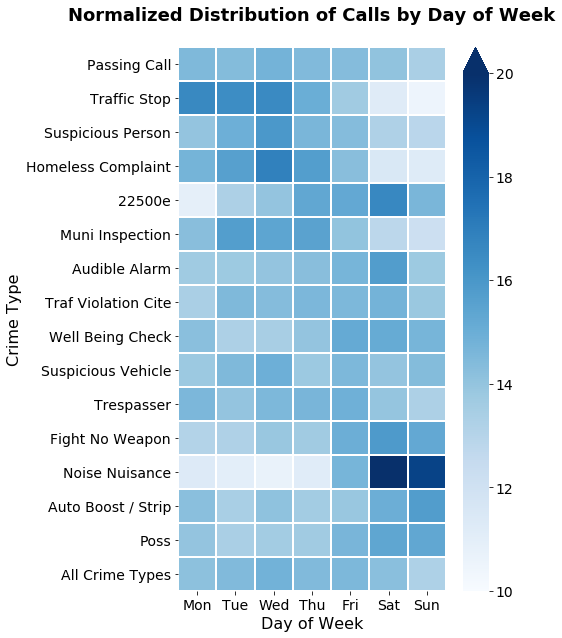

In [69]:
fig = plt.figure(figsize = (6,10))
ax = fig.add_subplot(1,1,1)
cbar_kws = {
            'extend':'max'
           }
sns.heatmap(total_calls_by_type_by_DayOfWeek_Fraction , cmap="Blues",linewidth = 1, cbar_kws = cbar_kws,
           vmin = 10, vmax = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel ('Day of Week' , fontsize = 16)
plt.ylabel ('Crime Type', fontsize = 16)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Normalized Distribution of Calls by Day of Week\n', fontsize = 18 , fontweight = 'bold')
plt.xticks ([0.5,1.5,2.5,3.5,4.5,5.5,6.5], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.savefig ('../Plots/calls/DailyDistribution_all_calls_by_type.pdf', bbox_inches = 'tight')

## What day of week had the most average daily calls for service in July 2018?

In [70]:
calls_July_2018 = calls.loc[(calls['Call Date Time'].dt.year == 2018)&(calls['Call Date Time'].dt.month == 7)]

In [71]:
### Total number of calls each day in July 2018
calls_July_2018_by_DayOfWeek = calls_July_2018.groupby('DayOfWeek')['Crime Id'].count()

In [72]:
### How many of each day exists in July 2018? 
start_date = '2018-07-01'
end_date = '2018-07-31'
idx = pd.date_range(pd.to_datetime(start_date) , pd.to_datetime(end_date))
July_dates_df = pd.DataFrame()
July_dates_df['date'] = idx
July_dates_df['DayOfWeek'] = July_dates_df['date'].apply(lambda x: x.weekday())

July_dates_grouped = July_dates_df.groupby('DayOfWeek')['date'].count()


In [73]:
calls_July_2018_by_DayOfWeek_Normalized = calls_July_2018_by_DayOfWeek/July_dates_grouped

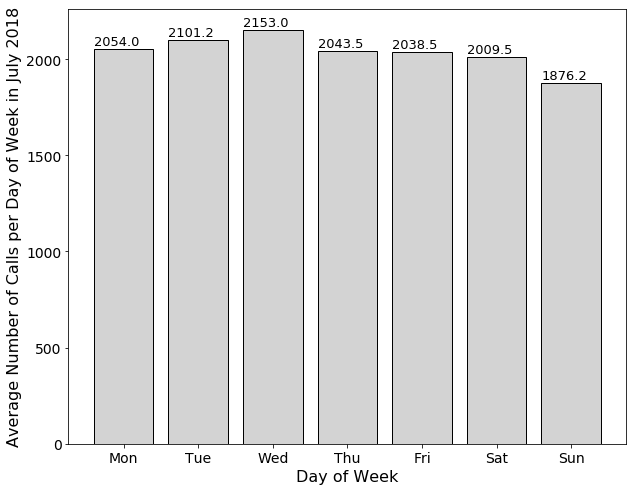

In [74]:
day_of_the_week_df = pd.DataFrame()
day_of_the_week_df['Numeric'] = np.arange(0,7)
day_of_the_week_df['String'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

xx = np.arange(len(calls_July_2018_by_DayOfWeek_Normalized))
yy = calls_July_2018_by_DayOfWeek_Normalized.values
x_label = 'Day of Week'
y_label = 'Average Number of Calls per Day of Week in July 2018'

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
plt.bar (xx , yy , color = 'lightgray',edgecolor = 'black')
for i in range(len(xx)):
    plt.text(xx[i]-0.4 , yy[i]+20 , str(round(yy[i],1)), fontsize = 13)
plt.xticks (day_of_the_week_df['Numeric'] , day_of_the_week_df['String'] , rotation= 0)
plt.xlabel(x_label, fontsize = 16)
plt.ylabel(y_label, fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig ('../Plots/calls/DayofWeek_2018_average_calls.pdf', bbox_inches = 'tight')

## Wednesday hast the most average daily calls for service in July 2018.